# Table of Contents

1. Loading data
2. EDA
3. Data Cleaning
4. Simple Feature Engineering
5. Visualizations

In [1]:
# basic imports
import pandas as pd
import numpy as np
import datetime as dt

# visualizations
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_theme(style='darkgrid', context='talk')

# time series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# settings
import warnings
warnings.filterwarnings('ignore')
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

### Step 1: Loading the Data (orders & items csv files)

In [2]:
# loading in orders & items tables
orders_df = pd.read_csv(r'C:\Users\Jagvir Dhesi\lighthouselabs\projects\demand-prediction-project\data\orders.csv', sep=';')
items_df = pd.read_csv(r'C:\Users\Jagvir Dhesi\lighthouselabs\projects\demand-prediction-project\data\items.csv', sep=';')

### Step 2: Exploratory Data Analysis (EDA)

#### 2.1 Orders EDA

In [3]:
# first look at orders table 
orders_df.head()

,order_id,date,payment,item_code,quantity,gift_quantity,unit_price_vat_excl,unit_cogs,unit_rrp_vat_excl,department,channel,owner,site,CreatedAt
0,2000093387,2020-04-24 00:00:00,GOPAY_CARD,S101,1,NaN,3.506048,0.000000,3.496395,E-COMMER,RUN.huC,RUN.huO,top4running.hu,2020-04-24 21:50:00
1,2000093387,2020-04-24 00:00:00,GOPAY_CARD,S113,1,NaN,-0.705913,0.000000,-0.717209,E-COMMER,RUN.huC,RUN.huO,top4running.hu,2020-04-24 21:50:00
2,2000093388,2020-04-24 00:00:00,COD,ZB00089178,1,NaN,5.829845,2.209302,6.472868,E-COMMER,FTB.czC,FTB.czO,11teamsports.cz,2020-04-24 21:45:00
3,2000093388,2020-04-24 00:00:00,COD,ZB00138060,1,NaN,5.829845,2.209302,6.472868,E-COMMER,FTB.czC,FTB.czO,11teamsports.cz,2020-04-24 21:45:00
4,2000093388,2020-04-24 00:00:00,COD,ZB00015664,1,NaN,19.379845,18.731008,32.015504,E-COMMER,FTB.czC,FTB.czO,11teamsports.cz,2020-04-24 21:45:00


- What is the difference between 'channel' and 'owner' ?



In [4]:
# check the number of rows and columns of the orders dataset
orders_df.shape

(2128524, 14)

We can see that the orders table has a lot of information, as seen by the larger number of rows. This will be beneficial for our models as we will have tons of historical data to make predictions from.

In [5]:
# check the overall info of the orders dataset 
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2128524 entries, 0 to 2128523
Data columns (total 14 columns):
 #   Column               Dtype  
---  ------               -----  
 0   order_id             int64  
 1   date                 object 
 2   payment              object 
 3   item_code            object 
 4   quantity             int64  
 5   gift_quantity        float64
 6   unit_price_vat_excl  float64
 7   unit_cogs            float64
 8   unit_rrp_vat_excl    float64
 9   department           object 
 10  channel              object 
 11  owner                object 
 12  site                 object 
 13  CreatedAt            object 
dtypes: float64(4), int64(2), object(8)
memory usage: 227.4+ MB


In [6]:
# see summary of the statistical measures of the numerical columns:
orders_df.describe()

,order_id,quantity,gift_quantity,unit_price_vat_excl,unit_cogs,unit_rrp_vat_excl
count,2.128524e+06,2.128524e+06,10390.000000,2.128524e+06,2.128524e+06,2.128426e+06
mean,2.039053e+09,1.029551e+00,1.000192,3.102203e+01,1.903846e+01,3.942803e+01
std,7.691450e+07,5.852888e-01,0.019621,4.066967e+01,2.665736e+01,5.013470e+01
min,2.000000e+07,-1.000000e+00,1.000000,-1.859721e+00,0.000000e+00,-1.771163e+00
25%,2.000112e+09,1.000000e+00,1.000000,2.551573e+00,0.000000e+00,2.613605e+00
50%,2.100026e+09,1.000000e+00,1.000000,1.442870e+01,7.829457e+00,2.034849e+01
75%,2.100322e+09,1.000000e+00,1.000000,4.481395e+01,2.871260e+01,5.810465e+01
max,2.200024e+09,1.360000e+02,3.000000,7.203857e+02,2.440504e+03,7.444543e+02


In [7]:
# check for duplicates in orders
order_duplicates = orders_df.duplicated()
print('Number of duplicates:', order_duplicates.sum())

Number of duplicates: 599


In [8]:
# view order_duplicates dataframe
order_duplicates_df = orders_df.duplicated()
orders_df[order_duplicates]

,order_id,date,payment,item_code,quantity,gift_quantity,unit_price_vat_excl,unit_cogs,unit_rrp_vat_excl,department,channel,owner,site,CreatedAt
164348,1900092622,2019-07-01 00:00:00,COD,ZB00018246,1,NaN,57.627132,44.215891,96.066279,E-COMMER,RUN.czC,VO_B_RUO,top4running.cz,2019-07-01 21:46:00
164349,1900092622,2019-07-01 00:00:00,COD,S101,1,NaN,2.850775,0.000000,2.850775,E-COMMER,RUN.czC,VO_B_RUO,top4running.cz,2019-07-01 21:46:00
164350,1900092622,2019-07-01 00:00:00,COD,S113,1,NaN,0.929070,0.000000,0.929070,E-COMMER,RUN.czC,VO_B_RUO,top4running.cz,2019-07-01 21:46:00
165359,1900093069,2019-07-02 00:00:00,COD,ZB00013773,1,NaN,133.570880,111.286822,190.808641,E-COMMER,FTB.huC,FTB.huO,11teamsports.hu,2019-07-02 13:02:00
165381,1900093077,2019-07-02 00:00:00,COD,ZB00004598,1,NaN,80.722481,44.492248,89.659690,E-COMMER,RUN.czC,RUN.czO,top4running.cz,2019-07-02 13:03:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672599,2100363952,2021-09-13 00:00:00,CARD_GOPAY,S114,-1,NaN,31.043965,0.000000,31.043965,E-COMMER,RUN.skC,RUN.skO,top4running.sk,2021-09-13 13:20:00
1691358,2100373980,2021-09-20 00:00:00,CARD_GOPAY,S114,-1,NaN,16.343707,0.000000,16.343707,E-COMMER,RUN.skC,RUN.skO,top4running.sk,2021-09-20 17:56:00
1767684,2100418711,2021-10-19 00:00:00,GOPAY_CARD,S114,-1,NaN,3.203101,0.000000,3.217054,E-COMMER,RUN.czC,RUN.czO,top4running.cz,2021-10-19 21:25:00
1771959,2100421188,2021-10-21 00:00:00,COD,S114,-1,NaN,3.054984,0.000000,3.065891,E-COMMER,RUN.huC,RUN.huO,top4running.hu,2021-10-21 16:42:00


It looks like order ids are duplicated but item codes are different for the same ids meaning that multiple items are being bought and classified under the same order id which is normal. Therefore, no need to remove these duplicates.

In [9]:
# check for missing values
orders_df.isnull().sum()

order_id                     0
date                         0
payment                    567
item_code                    0
quantity                     0
gift_quantity          2118134
unit_price_vat_excl          0
unit_cogs                    0
unit_rrp_vat_excl           98
department                   0
channel                      0
owner                        0
site                         0
CreatedAt                    0
dtype: int64

- payment: The missing values in this column could indicate that some orders were not paid for, or the payment method was not recorded for some orders. Should check in more detail.

- gift_quantity: The missing values in this column could indicate that most orders were not gifts, or the gift quantity was not recorded for most gift orders. Therefore we can leave these as is.

- unit_rrp_vat_excl: The missing values in this column could indicate that the recommended retail price was not available for some items, or the data was not properly recorded. Most likely will not use this column for evaluation so it can be dropped later on.

In [10]:
# check payments column in more detail by seeing all the nulls per date
orders_df.groupby('date')['payment'].apply(lambda x: x.isnull().sum())

date
2019-06-01 00:00:00      0
2019-06-02 00:00:00      0
2019-06-03 00:00:00      0
2019-06-04 00:00:00      0
2019-06-05 00:00:00      0
                      ... 
2022-01-10 00:00:00      0
2022-01-11 00:00:00      0
2022-01-12 00:00:00      0
2022-01-13 00:00:00      0
2022-01-14 00:00:00    563
Name: payment, Length: 958, dtype: int64

We can see most of the null values in payments happened on January 14, 2022. This might indicate some sort of payment/service error and therefore I will drop these values.

In [11]:
# print minimum and maximum date ranges:
print(f"Orders date range: {orders_df['date'].min()} to {orders_df['date'].max()}")

Orders date range: 2019-06-01 00:00:00 to 2022-01-14 00:00:00


In [12]:
# site URLs reveal which country each order is from
orders_df['site'].value_counts()

11teamsports.cz    390570
11teamsports.sk    206680
top4running.cz     205022
11teamsports.ro    202106
11teamsports.hu    175751
                    ...  
top4football.be        70
top4fitness.si         43
top4running.uk         14
top4fitness.bg          4
11teamsports.bg         2
Name: site, Length: 70, dtype: int64

In [13]:
# check most frequent item codes
orders_df['item_code'].value_counts()

S101          406708
S113          347381
S114           15649
ZB00077277      2398
ZB00053597      2070
               ...  
ZB00123101         1
ZB00038248         1
ZB00123102         1
ZB00123104         1
ZB00286718         1
Name: item_code, Length: 222419, dtype: int64

We can see that item_codes: S101, S113, S114 are the most frequent. What do these mean? in order to check what each item code corresponds to we will need to check against the items table

In [14]:
S101 = items_df['item_code']=='S101'
items_df[S101].head(1)

,item_code,item_name,style,brand_id,name,group0_id,group0,group1_id,group1,group2_id,group2,category,gender,age,color,size
306868,S101,Dopravné,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# find item_name that corresponds to item code 'S101'
S101 = items_df['item_code']=='S101'
items_df[S101].head(1)

,item_code,item_name,style,brand_id,name,group0_id,group0,group1_id,group1,group2_id,group2,category,gender,age,color,size
306868,S101,Dopravné,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# find item_name that corresponds to item code 'S113'
S113 = items_df['item_code']=='S113'
items_df[S113].head(1)

,item_code,item_name,style,brand_id,name,group0_id,group0,group1_id,group1,group2_id,group2,category,gender,age,color,size
307919,S113,Platba,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# find item_name that corresponds to item code 'S114'
S114 = items_df['item_code']=='S114'
items_df[S114].head(1)

,item_code,item_name,style,brand_id,name,group0_id,group0,group1_id,group1,group2_id,group2,category,gender,age,color,size
308992,S114,Sleva,NaN,-1,- žádný výrobce -,999.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


What do each of the item codes stand for:
- item code S101 = Dopravné which translates to freight
- item code S113 = Platba which translates to payment
- item code S114 = Sleva which translates to discount

On a side note the name: žádný výrobce is = no manufacturer

Since we are prediciting demand it may be useful for our analysis to remove these items as they are not actual products that our client sells.

#### Items EDA

In [18]:
# first look at items table 
items_df.head()

,item_code,item_name,style,brand_id,name,group0_id,group0,group1_id,group1,group2_id,group2,category,gender,age,color,size
0,ZB00210807,Studio Metallic LS Top,51951501,86,Puma,200.0,Apparel,230.0,T-Shirts,233.0,Longsleeved (LS) shirts,fitness,women,adults,Black,L
1,ZB00210813,TRAIN TECH EVOKNIT SS TEE,52011101,86,Puma,200.0,Apparel,230.0,T-Shirts,0.0,NaN,fitness,men,adults,Black,S
2,ZB00210815,TRAIN TECH EVOKNIT SS TEE,52011123,86,Puma,200.0,Apparel,230.0,T-Shirts,0.0,NaN,fitness,men,adults,Orange,L
3,ZB00210821,TRAIN TECH EVOKNIT SS TEE,52011130,86,Puma,200.0,Apparel,230.0,T-Shirts,0.0,NaN,fitness,men,adults,Yellow,XL
4,ZB00261295,LIGA Baselayer Tee LS,655920-027,86,Puma,200.0,Apparel,230.0,T-Shirts,233.0,Longsleeved (LS) shirts,football,men,adults,Green,L


In [19]:
# check the overall info of the items dataset 
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309128 entries, 0 to 309127
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   item_code  309128 non-null  object 
 1   item_name  306002 non-null  object 
 2   style      302331 non-null  object 
 3   brand_id   309128 non-null  int64  
 4   name       309128 non-null  object 
 5   group0_id  309093 non-null  float64
 6   group0     308302 non-null  object 
 7   group1_id  301709 non-null  float64
 8   group1     265348 non-null  object 
 9   group2_id  301709 non-null  float64
 10  group2     71773 non-null   object 
 11  category   269282 non-null  object 
 12  gender     301644 non-null  object 
 13  age        301562 non-null  object 
 14  color      263532 non-null  object 
 15  size       301087 non-null  object 
dtypes: float64(3), int64(1), object(12)
memory usage: 37.7+ MB


In [20]:
# check the number of rows and columns of the items dataset
items_df.shape

(309128, 16)

In [21]:
# see summary of the statistical measures of the numerical columns:
items_df.describe()

,brand_id,group0_id,group1_id,group2_id
count,309128.000000,309093.000000,301709.000000,301709.000000
mean,96.129768,174.490247,168.309994,49.662135
std,35.064212,141.565159,86.074512,93.666764
min,-1.000000,0.000000,0.000000,0.000000
25%,84.000000,100.000000,110.000000,0.000000
50%,85.000000,200.000000,199.000000,0.000000
75%,93.000000,200.000000,230.000000,0.000000
max,263.000000,999.000000,999.000000,327.000000


In [22]:
# check for duplicates in items
item_duplicates = items_df.duplicated()
print('Number of duplicates:', item_duplicates.sum())

Number of duplicates: 0


In [23]:
# check for missing values
items_df.isnull().sum()

item_code         0
item_name      3126
style          6797
brand_id          0
name              0
group0_id        35
group0          826
group1_id      7419
group1        43780
group2_id      7419
group2       237355
category      39846
gender         7484
age            7566
color         45596
size           8041
dtype: int64

We can see that there are alot of null values in this dataframe. I would say 'item_name' is the most imporant column to check as it gives the most valuable information about the items. 

In [24]:
# check counts for each item_name
items_df['item_name'].value_counts()

DUPLICITNÍ ARTIKL                         427
UA Classic Slip-On                        397
GEL-NIMBUS 23                             343
React Infinity Run Flyknit 2              328
NIKE AIR ZOOM PEGASUS 36                  323
                                         ... 
Under Armour AF Graphic                     1
FFF Strike                                  1
U NK HERTHA BSC HOME DRY SOCKS 2020/21      1
Borussia Dortmund Away 2019/20              1
iPhone 7 32GB Black                         1
Name: item_name, Length: 33788, dtype: int64

In [25]:
# check counts for 'group0'
items_df['group0'].value_counts()

Footwear     150127
Apparel      137334
Equipment     13121
Other          7386
Nutrition       277
Services         57
Name: group0, dtype: int64

In [26]:
# check null values for 'group0_id'
group0_null = items_df['group0_id'].isna()
items_df[group0_null].head(10)

,item_code,item_name,style,brand_id,name,group0_id,group0,group1_id,group1,group2_id,group2,category,gender,age,color,size
108430,ZB00308133,voucher-t4r-50-eur-de,voucher-t4r-50-eur-de,87,Topforsport,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex,adults,NaN,ks
111837,ZB00308709,voucher-t4r-50-eur-es,voucher-t4r-50-eur-es,87,Topforsport,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unisex,adults,NaN,ks
305358,DRM0361,Notebook HP ProBook 450 G8,NaN,-1,- žádný výrobce -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305479,S128,Poukaz_uplatnení,NaN,-1,- žádný výrobce -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305946,DRM0060,Notebook Lenovo ThinkPad 13,NaN,-1,- žádný výrobce -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305959,DRM0349,IPHONE SE RED 64GB-CSC,NaN,-1,- žádný výrobce -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306226,DRM0358,Notebook Lenovo IdealPad 3 15ITL6,NaN,-1,- žádný výrobce -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306243,DRM0344,Notebook Lenovo IdeaPad S340,NaN,-1,- žádný výrobce -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306541,S134,Marketingový príspevek_fa pred,NaN,-1,- žádný výrobce -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306586,DRM0359,Notebook Lenovo IdealPad 5 15ARE5 Platinum Grey,NaN,-1,- žádný výrobce -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Electronics are in this group for some reason and should be removed as our client does not sell these items

In [27]:
# check counts for 'group1'
items_df['group1'].value_counts()

Running shoes      45942
Football shoes     40562
T-Shirts           39425
Other Footwear     35139
Pants              29492
Sweatshirts        16083
Jackets            10997
Jerseys             8741
Fitness Shoes       7569
Socks               6883
Gloves              4593
Bras                3549
Slides              2307
Tracksuits          1923
Guards              1396
Underwear           1377
Other Apparel       1351
Balls               1221
Caps                1100
Backpacks           1037
Bags                 780
Vests                688
Other Equipment      570
Beanies              534
Training             463
Glasses              267
Skirts               187
Gymsacks             182
Sporttesters         174
Dress                159
Hydrate              134
Lamps                125
Sports gloves        118
Other                 82
Other nutrition       61
Earphones             46
Bar                   44
Tank                  29
Pumps                 15
Football socks         3


In [28]:
# check null values for 'group1'
group1_null = items_df['group1_id'].isna()
items_df[group1_null].head()

,item_code,item_name,style,brand_id,name,group0_id,group0,group1_id,group1,group2_id,group2,category,gender,age,color,size
1410,ZB00151257,Popcat 20 Bold Palace Blue-Dark Denim-Me,37262802,86,Puma,999.0,Other,NaN,NaN,NaN,NaN,NaN,unisex,adults,NaN,47
1411,ZB00151259,Popcat 20 Bold Palace Blue-Dark Denim-Me,37262802,86,Puma,999.0,Other,NaN,NaN,NaN,NaN,NaN,unisex,adults,NaN,46
1660,ZB00220924,erima sport bag club 5 gr s,723333,132,Erima,999.0,Other,NaN,NaN,NaN,NaN,NaN,unisex,adults,NaN,L
2243,ZB00227818,TE Piping Tracksuit,gs9309,88,Reebok,999.0,Other,NaN,NaN,NaN,NaN,NaN,men,adults,NaN,XXL
2303,ZB00151226,ftblPLAY Training Pant Puma Black,65593301,86,Puma,999.0,Other,NaN,NaN,NaN,NaN,NaN,men,adults,NaN,M


In [29]:
# check counts for 'group2'
items_df['group2'].value_counts()

Shorts                     16248
With hood                  10882
Trail                       8938
Longsleeved (LS) shirts     7973
Indoor/Court (IC)           6333
Tank                        5983
Spikes                      4795
Football gloves             3803
Football socks              2321
Polo                        1942
Compression shirts          1070
43924                        704
Compression pants            482
Sleeveless (SL) shirts       181
Fitness gloves               118
Name: group2, dtype: int64

In [30]:
# check null values for 'group2_id'
group2_null = items_df['group2_id'].isna()
items_df[group2_null].head()

,item_code,item_name,style,brand_id,name,group0_id,group0,group1_id,group1,group2_id,group2,category,gender,age,color,size
1410,ZB00151257,Popcat 20 Bold Palace Blue-Dark Denim-Me,37262802,86,Puma,999.0,Other,NaN,NaN,NaN,NaN,NaN,unisex,adults,NaN,47
1411,ZB00151259,Popcat 20 Bold Palace Blue-Dark Denim-Me,37262802,86,Puma,999.0,Other,NaN,NaN,NaN,NaN,NaN,unisex,adults,NaN,46
1660,ZB00220924,erima sport bag club 5 gr s,723333,132,Erima,999.0,Other,NaN,NaN,NaN,NaN,NaN,unisex,adults,NaN,L
2243,ZB00227818,TE Piping Tracksuit,gs9309,88,Reebok,999.0,Other,NaN,NaN,NaN,NaN,NaN,men,adults,NaN,XXL
2303,ZB00151226,ftblPLAY Training Pant Puma Black,65593301,86,Puma,999.0,Other,NaN,NaN,NaN,NaN,NaN,men,adults,NaN,M


In [31]:
# how many unique products?
items_df.item_code.nunique()

309128

### Step 3: Data Cleaning

To do:
- drop null values from 'payment' and 'group0_id'
- fill 'category' and 'group0' columns in items table with 'other'
- convert 'date' and 'CreatedAt' columns to datetime objects
- select country name from 'site' column and replace country abbreviation with full names
- drop '.com' ending sites as we are focused on European market
- remove item codes  'S101', 'S113', and 'S114' as they are not products our client sells
- drop columns from orders and items table that are not needed
- rename columns for readability

In [32]:
# create function that will clean both items and orders csvs and make a new combined cleaned csv file:

def clean(orders_df, items_df):
    # drop null columns
    orders_df.dropna(subset=['payment'], inplace=True)
    items_df.dropna(subset=['group0_id'], inplace=True)
    
    # fill columns in items table with 'other'
    items_df['category'].fillna('other', inplace=True)
    items_df['group0'].fillna('other', inplace=True)
    
    # convert columns to datetime objects
    orders_df['date'] = pd.to_datetime(orders_df['date'])
    orders_df['CreatedAt'] = pd.to_datetime(orders_df['CreatedAt'])
    
    # select country name from 'site' column
    orders_df['country'] = orders_df['site'].apply(lambda x: x.split('.')[1] if len(x.split('.')) >= 2 else '')
    # drop site names ending in 'com' as we are focused on the European market
    orders_df.drop(orders_df[orders_df['country']=='com'].index, inplace=True)
    # replace country abbreviation with full names
    orders_df['country'] = orders_df['country'].replace(
        {'at':'Austria', 'be':'Belgium', 'bg':'Bulgaria', 'cz':'Czech Republic', 'dk':'Denmark',
        'de':'Germany', 'es':'Spain', 'fi':'Finland', 'fr':'France', 'hr':'Croatia', 'hu':'Hungary',
        'ie':'Ireland', 'it':'Italy', 'nl':'Netherlands', 'pl':'Poland', 'pt':'Portugal', 'ro':'Romania',
        'se':'Sweden', 'si':'Slovenia', 'sk':'Slovakia', 'uk':'United Kingdom'})
    
    # drop columns from orders table that are not needed
    orders_df = orders_df.drop(['payment', 'department', 'channel', 'owner', 'gift_quantity', 'site', 'CreatedAt', 'unit_rrp_vat_excl'], axis=1)
    # drop columns from items table that are not needed
    items_df = items_df.drop(['brand_id','group0_id', 'group1_id', 'group2_id', 'color', 'size'], axis=1)
    
    # renanme columns in orders table for readability
    orders_df = orders_df.rename(columns={'unit_price_vat_excl': 'unit_price'})
    
    # create new orders dataframe the excludes item codes S101, S113 and S114
    orders_final_df = orders_df[~orders_df['item_code'].isin(['S101', 'S113', 'S114'])]

    # merge orders and items tables together on 'item_code' column
    cleaned_df = pd.merge(orders_final_df, items_df, on='item_code',)
    
    # save cleaned dataframe to a new CSV file
    cleaned_df.to_csv(r'C:\Users\Jagvir Dhesi\lighthouselabs\projects\demand-prediction-project\data\cleaned_data.csv', index=False)
    
    return cleaned_df

In [33]:
# run the clean function on our dataframes
cleaned_df = clean(orders_df, items_df)

In [34]:
# check to see the missing valeus after cleaning and merging of orders and items tables:
cleaned_df.isnull().sum()

order_id           0
date               0
item_code          0
quantity           0
unit_price         0
unit_cogs          0
country            0
item_name          5
style            166
name               0
group0             0
group1         32043
group2        950811
category           0
gender           418
age              439
dtype: int64

In [35]:
# see which 'item_name' rows are missing inputs
null_item_names = cleaned_df[cleaned_df['item_name'].isnull()]
null_item_names

,order_id,date,item_code,quantity,unit_price,unit_cogs,country,item_name,style,name,group0,group1,group2,category,gender,age
513051,1900092396,2019-07-01,ZB00002126,1,25.465891,18.507752,Czech Republic,NaN,724762-010,Nike,Other,NaN,NaN,other,NaN,NaN
513052,1900102020,2019-07-16,ZB00002126,1,22.208837,18.507752,Hungary,NaN,724762-010,Nike,Other,NaN,NaN,other,NaN,NaN
513053,1900138282,2019-09-02,ZB00002126,1,25.111434,18.507752,Slovakia,NaN,724762-010,Nike,Other,NaN,NaN,other,NaN,NaN
544282,1900106546,2019-07-24,ZB00063323,1,25.465891,43.139535,Czech Republic,NaN,724762-010,Nike,Other,NaN,NaN,other,NaN,NaN
1333376,2200023777,2022-01-13,ZB00308849,1,16.720930,8.527132,Czech Republic,NaN,NaN,- žádný výrobce -,Other,NaN,NaN,other,NaN,NaN


In [36]:
# can drop these 5 rows as they will be insignificant to overall data
cleaned_df.dropna(subset=['item_name'], inplace=True)

In [37]:
# check to see if null 'item_name' are dropped
cleaned_df.isnull().sum()

order_id           0
date               0
item_code          0
quantity           0
unit_price         0
unit_cogs          0
country            0
item_name          0
style            165
name               0
group0             0
group1         32038
group2        950806
category           0
gender           413
age              434
dtype: int64

In [38]:
cleaned_df.shape

(1333379, 16)

In [65]:
print(cleaned_df['date'].dtypes)

datetime64[ns]


In [66]:
print(orders_df['date'].dtype)

datetime64[ns]


In [41]:
# see the unique number of manufacturers for top4sports
manufacturers=cleaned_df.name.nunique()
print(f'There are {manufacturers} manufacturers')

There are 130 manufacturers


I will choose to keep the null values as is instead of removing since the other data in these rows is crucial for our future analysis. Imputing these columns will also skew the data too much as we have a large number of missing values.

### Step 4: Simple Feature Engineering 

In [42]:
# load in cleaned dataframe:
cleaned_df = pd.read_csv(r'C:\Users\Jagvir Dhesi\lighthouselabs\projects\demand-prediction-project\data\cleaned_data.csv')

In [43]:
cleaned_df.head()

,order_id,date,item_code,quantity,unit_price,unit_cogs,country,item_name,style,name,group0,group1,group2,category,gender,age
0,2000093388,2020-04-24,ZB00089178,1,5.829845,2.209302,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults
1,1900182328,2019-11-04,ZB00089178,1,5.686483,0.000000,Slovakia,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults
2,1900186164,2019-11-10,ZB00089178,1,4.965116,2.373643,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults
3,2000058563,2020-03-07,ZB00089178,1,4.965116,2.209302,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults
4,2000297106,2020-11-24,ZB00089178,1,4.772868,2.364341,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults


Based on the above columns we can create useful features/columns that can add detail to our data.

For example:
- Sales Revenue
- Gross Profit
- Profit Margin



In [44]:
# create sales revenue column
cleaned_df['sales_revenue'] = cleaned_df['quantity'] * cleaned_df['unit_price']

# create gross profit column
cleaned_df['gross_profit'] = (cleaned_df['unit_price'] - cleaned_df['unit_cogs']) * cleaned_df['quantity']

# create profit margin column
cleaned_df['profit_margin'] = cleaned_df['gross_profit'] / cleaned_df['unit_price']

In [45]:
cleaned_df.head()

,order_id,date,item_code,quantity,unit_price,unit_cogs,country,item_name,style,name,group0,group1,group2,category,gender,age,sales_revenue,gross_profit,profit_margin
0,2000093388,2020-04-24,ZB00089178,1,5.829845,2.209302,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,5.829845,3.620543,0.621036
1,1900182328,2019-11-04,ZB00089178,1,5.686483,0.000000,Slovakia,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,5.686483,5.686483,1.000000
2,1900186164,2019-11-10,ZB00089178,1,4.965116,2.373643,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,4.965116,2.591473,0.521936
3,2000058563,2020-03-07,ZB00089178,1,4.965116,2.209302,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,4.965116,2.755814,0.555035
4,2000297106,2020-11-24,ZB00089178,1,4.772868,2.364341,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,4.772868,2.408527,0.504629


In [46]:
# what is the total sales revenue?
total_sales_revenue = cleaned_df['sales_revenue'].sum().round(2)
print('Total sales revenue:', total_sales_revenue)

Total sales revenue: 63841995.54


In [47]:
# what is the total gross profit?
total_gross_profit = cleaned_df['gross_profit'].sum().round(2)
print('Total gross profit:', total_gross_profit)

Total gross profit: 23718109.39


In [48]:
# force 'date' column to datetime object:
cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])

In [49]:
# save csv file so we have these new features:
cleaned_df.to_csv(r'C:\Users\Jagvir Dhesi\lighthouselabs\projects\demand-prediction-project\data\cleaned_data.csv', index=False)

### Step 5: Visualizations

#### Orders by Manufacturers

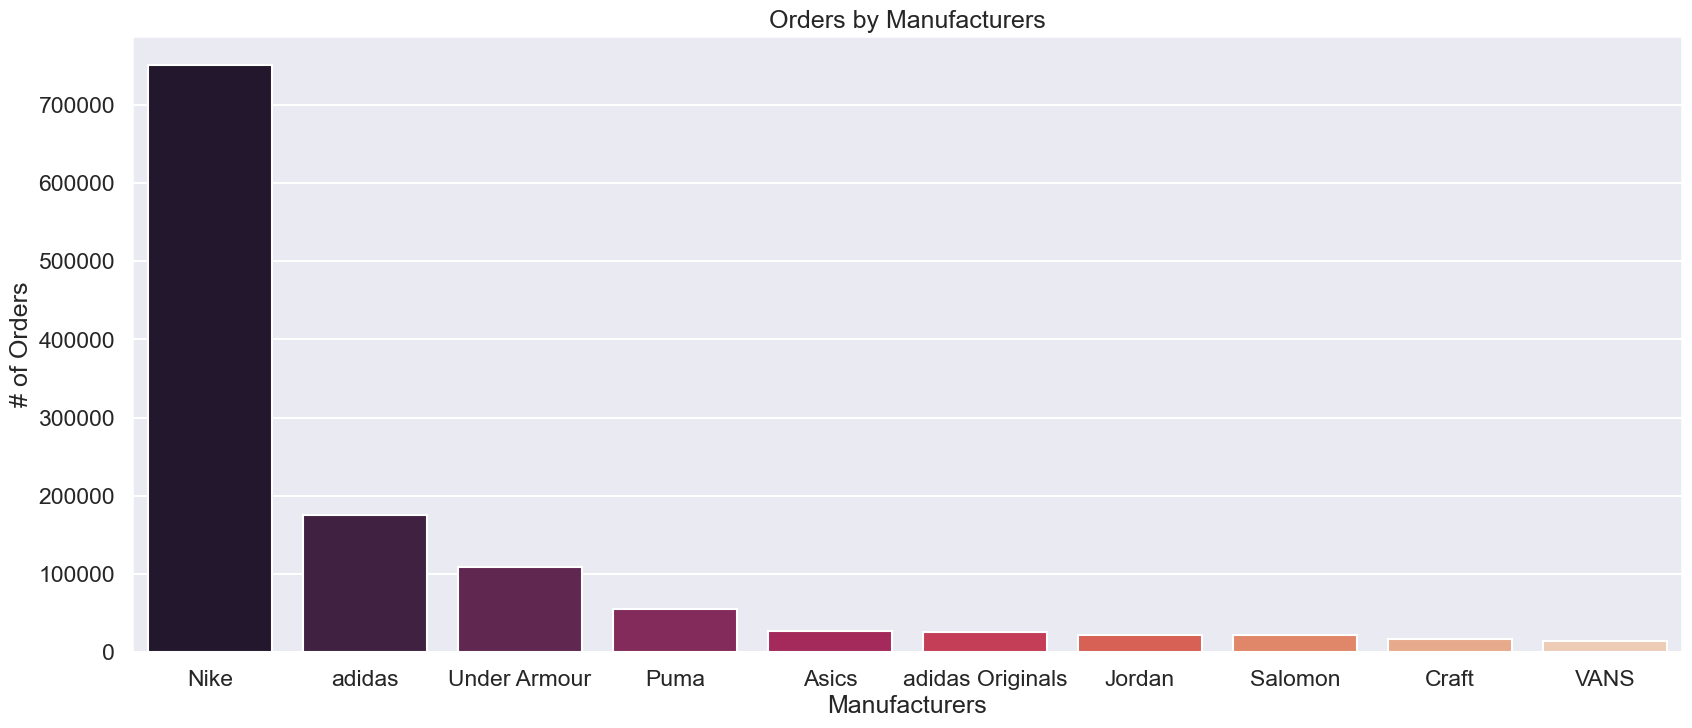

In [50]:
# plot the top 10 manufacturers by order numbers
manufacturers = cleaned_df['name'].value_counts().head(10)

plt.figure(figsize=(20, 8))
sns.barplot(x=manufacturers.index, y=manufacturers.values, palette='rocket')
plt.ylabel('# of Orders')
plt.xlabel('Manufacturers')
plt.title('Orders by Manufacturers')

plt.show()

#### Orders Volume by Category

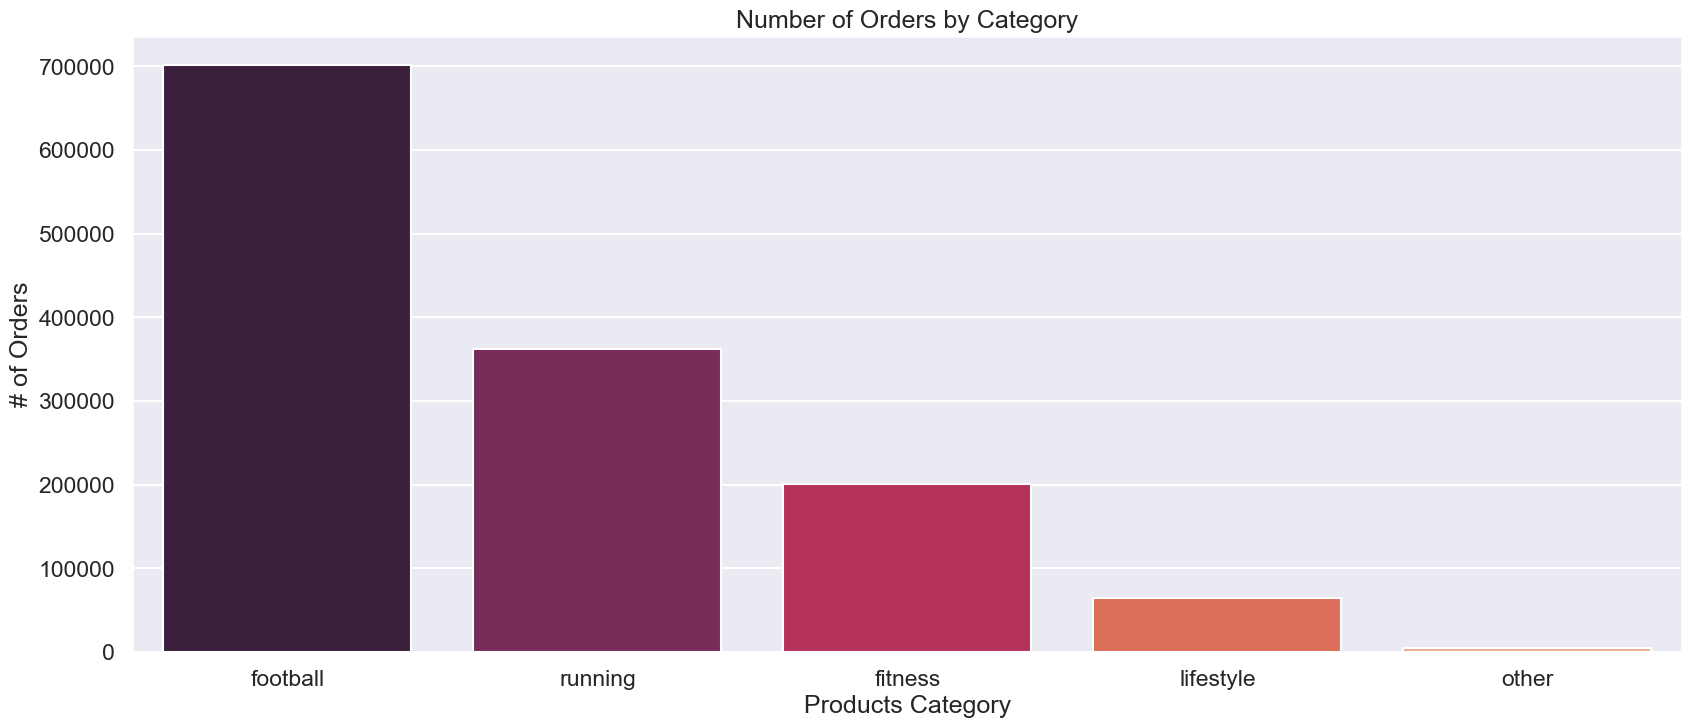

In [51]:
# plot categories by number of orders
category = cleaned_df['category'].value_counts()

plt.figure(figsize=(20, 8))
sns.barplot(x=category.index, y=category.values, palette='rocket')
plt.xlabel('Products Category')
plt.ylabel('# of Orders')
plt.title('Number of Orders by Category')

plt.show()

#### Group Orders by Product Types

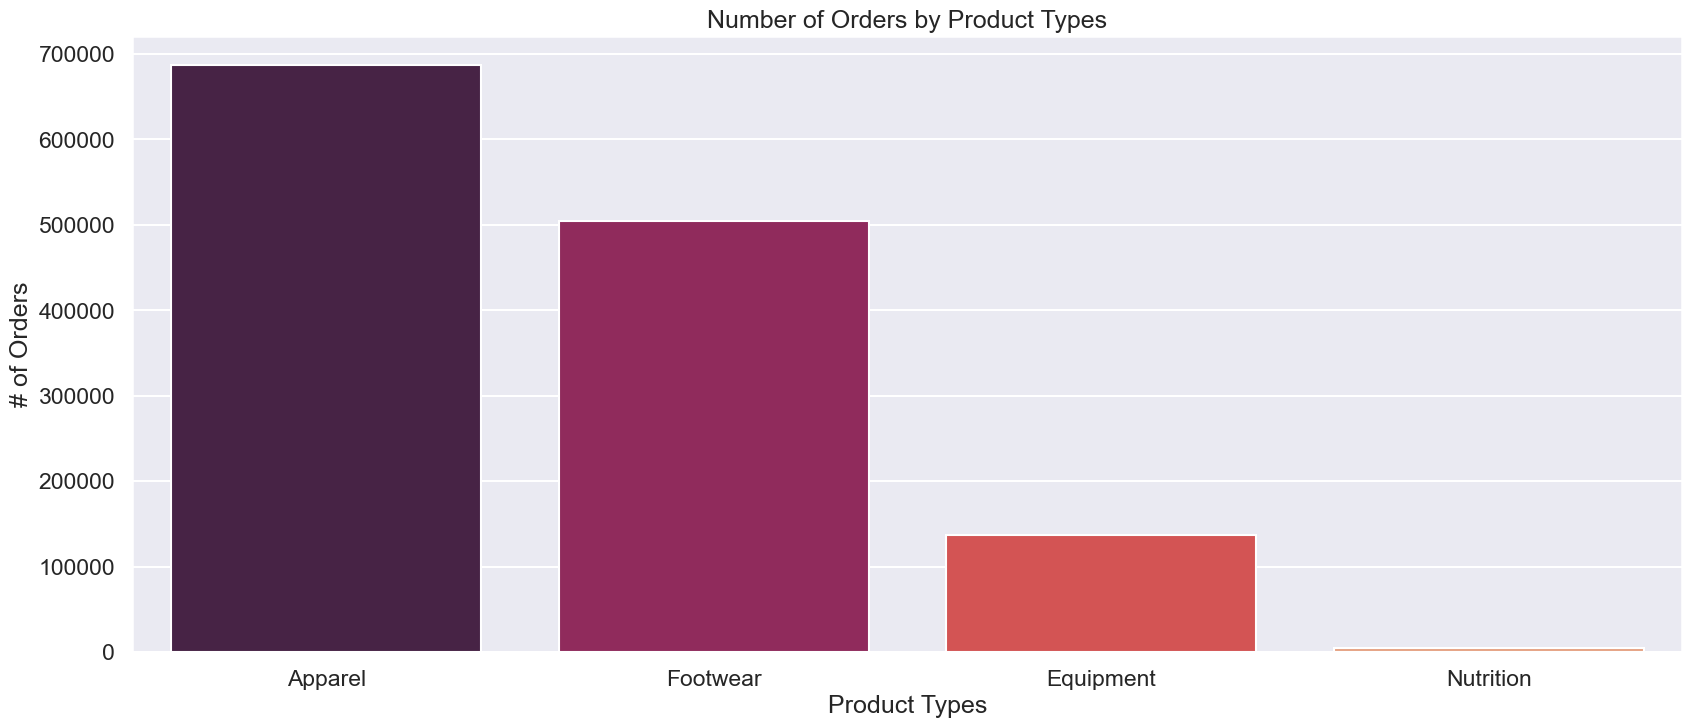

In [52]:
# plot product types by number of orders
product_types = cleaned_df['group0'].value_counts()

plt.figure(figsize=(20, 8))
sns.barplot(x=product_types.index[:4], y=product_types.values[:4], palette='rocket')
plt.xlabel('Product Types')
plt.ylabel('# of Orders')
plt.title('Number of Orders by Product Types')

plt.show()

#### Group Orders by More Detailed Product Types

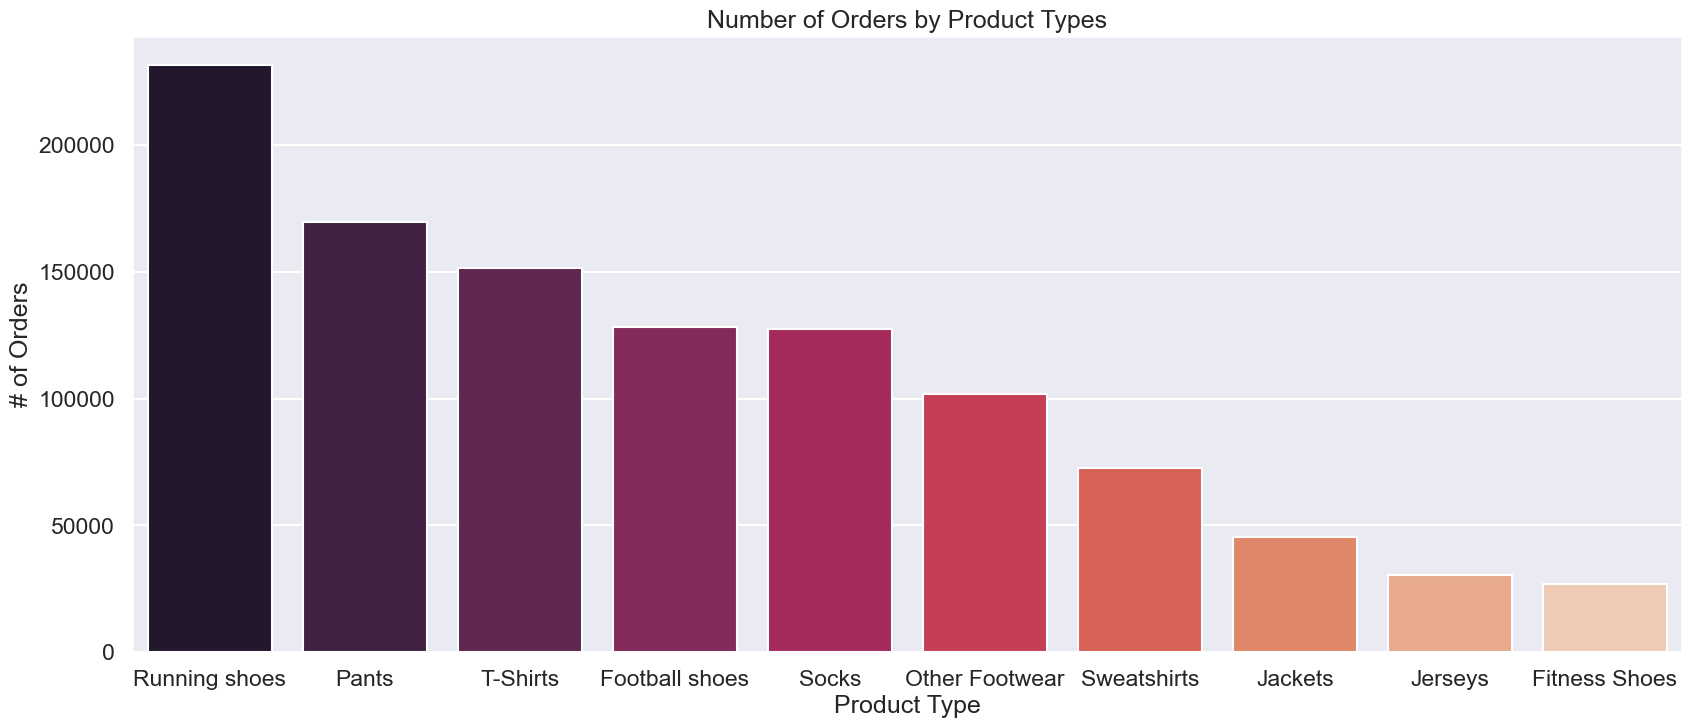

In [53]:
# plot top 10 product types by number of orders
product_types = cleaned_df['group1'].value_counts()

plt.figure(figsize=(20, 8))
sns.barplot(x=product_types.index[:10], y=product_types.values[:10], palette='rocket')
plt.xlabel('Product Type')
plt.ylabel('# of Orders')
plt.title('Number of Orders by Product Types')

plt.show()

#### Orders by Country

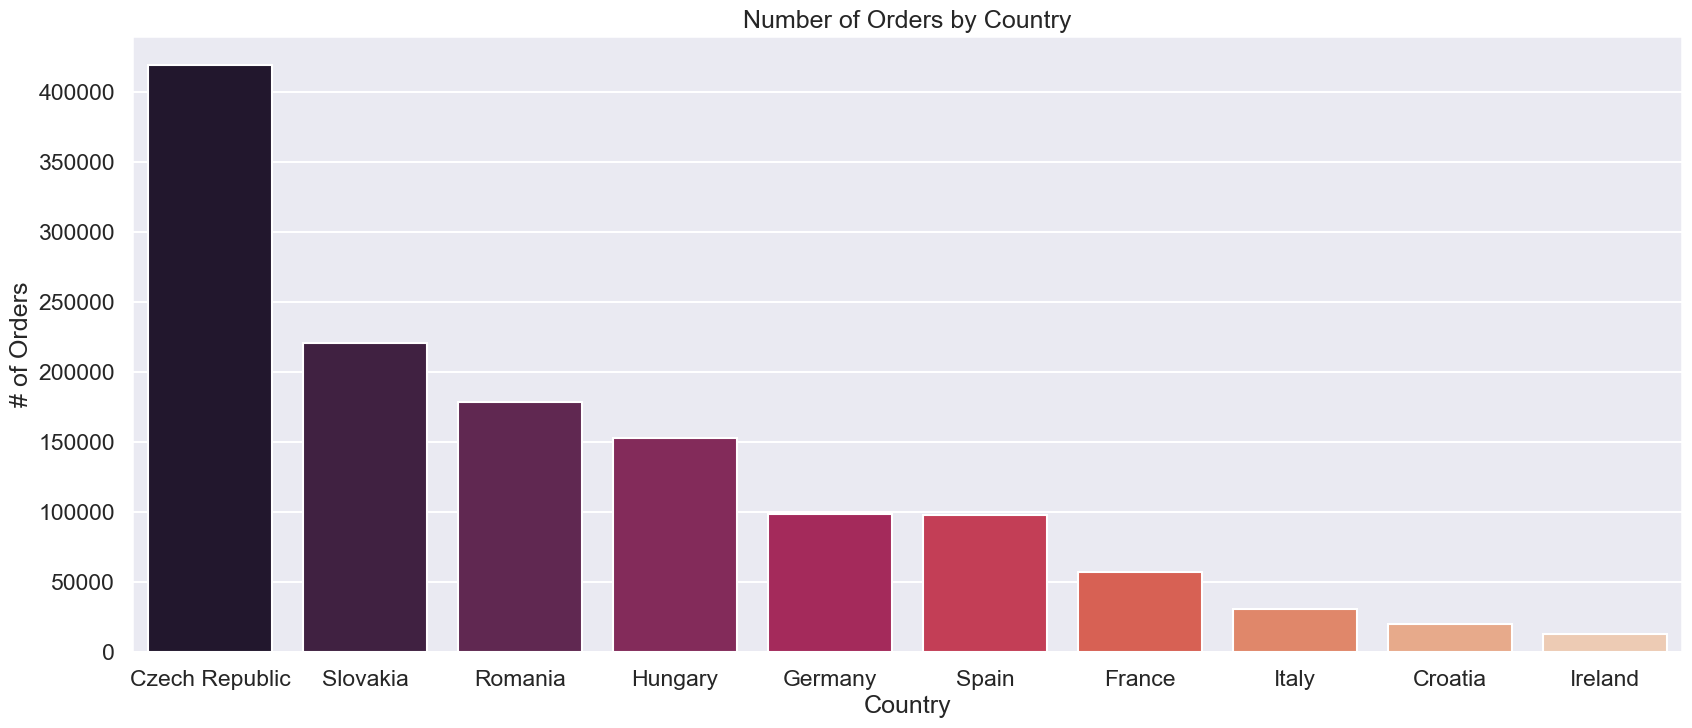

In [54]:
# plot top 10 countries by number of orders
country = cleaned_df['country'].value_counts()

plt.figure(figsize=(20, 8))
sns.barplot(x=country.index[:10], y=country.values[:10], palette='rocket')
plt.xlabel('Country')
plt.ylabel('# of Orders')
plt.title('Number of Orders by Country')

plt.show()

#### Revenue by Country 

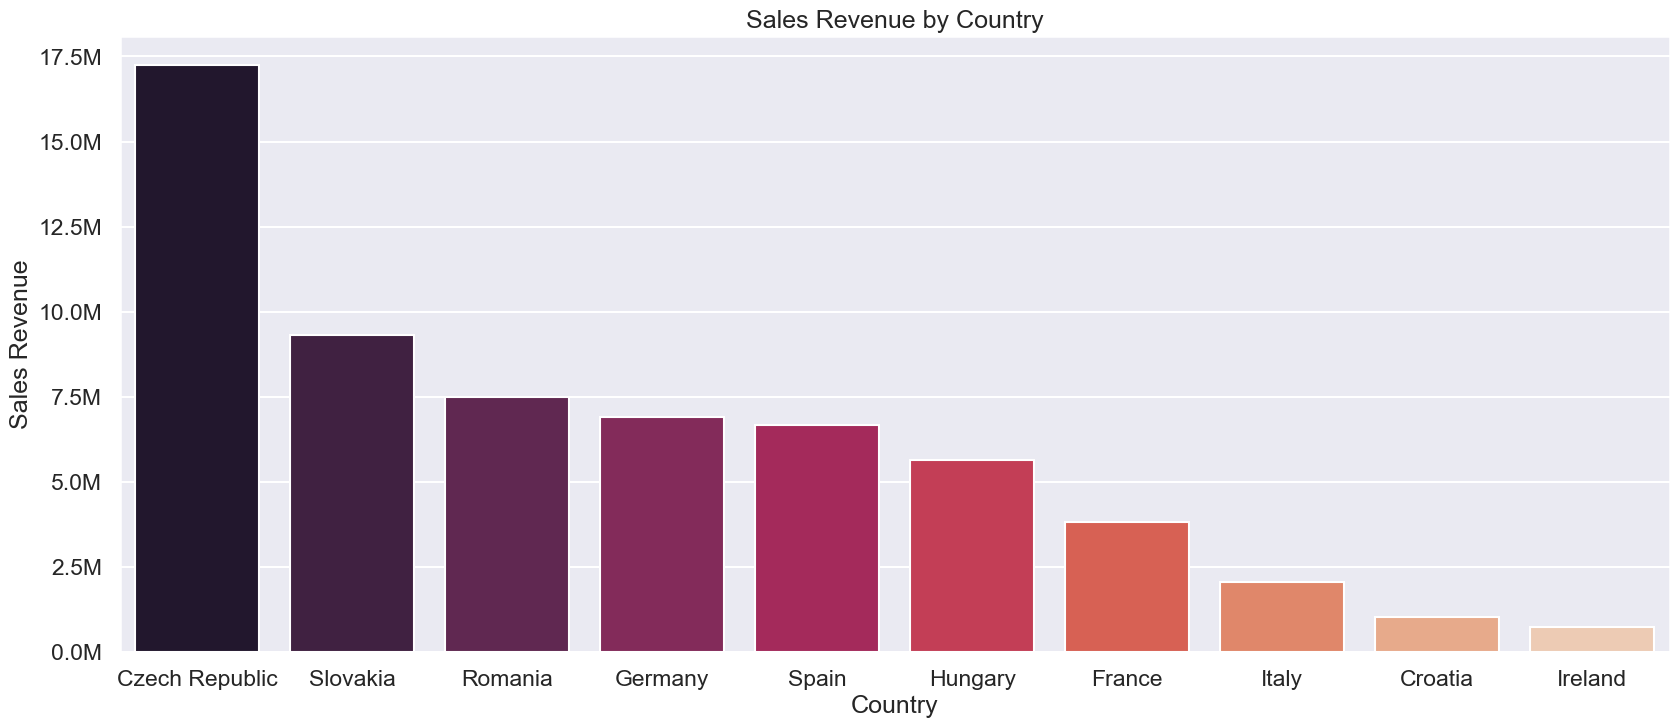

In [55]:
# plot sales revenue by top 10 countries
sales_by_country = cleaned_df.groupby('country')['sales_revenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(20, 8))
sns.barplot(x=sales_by_country.index, y=sales_by_country.values, palette='rocket')
plt.xlabel('Country')
plt.ylabel('Sales Revenue')
plt.title('Sales Revenue by Country')

# format y-axis values to display in millions with one decimal place
formatter = ticker.FuncFormatter(lambda x, pos: '{:.1f}M'.format(x/1000000))
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

#### Revenue by Category

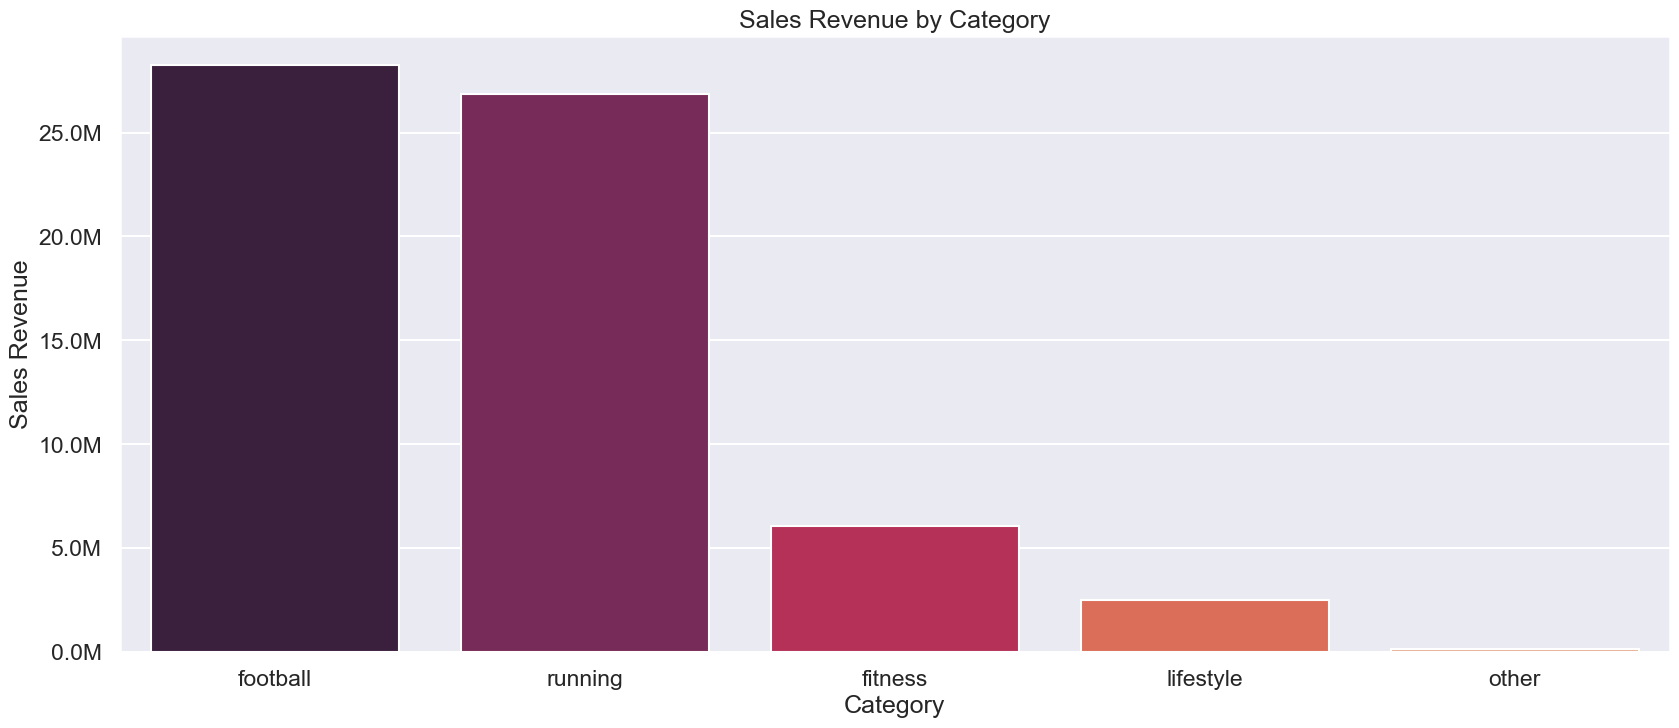

In [56]:
# plot sales revenue by top 10 countries
category_revenue = cleaned_df.groupby('category')['sales_revenue'].sum().sort_values(ascending=False)

plt.figure(figsize=(20, 8))
sns.barplot(x=category_revenue.index[:10], y=category_revenue.values[:10], palette='rocket')
plt.xlabel('Category')
plt.ylabel('Sales Revenue')
plt.title('Sales Revenue by Category')

# format y-axis values to display in millions with one decimal place
formatter = ticker.FuncFormatter(lambda x, pos: '{:.1f}M'.format(x/1000000))
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

#### Revenue by Detailed Category

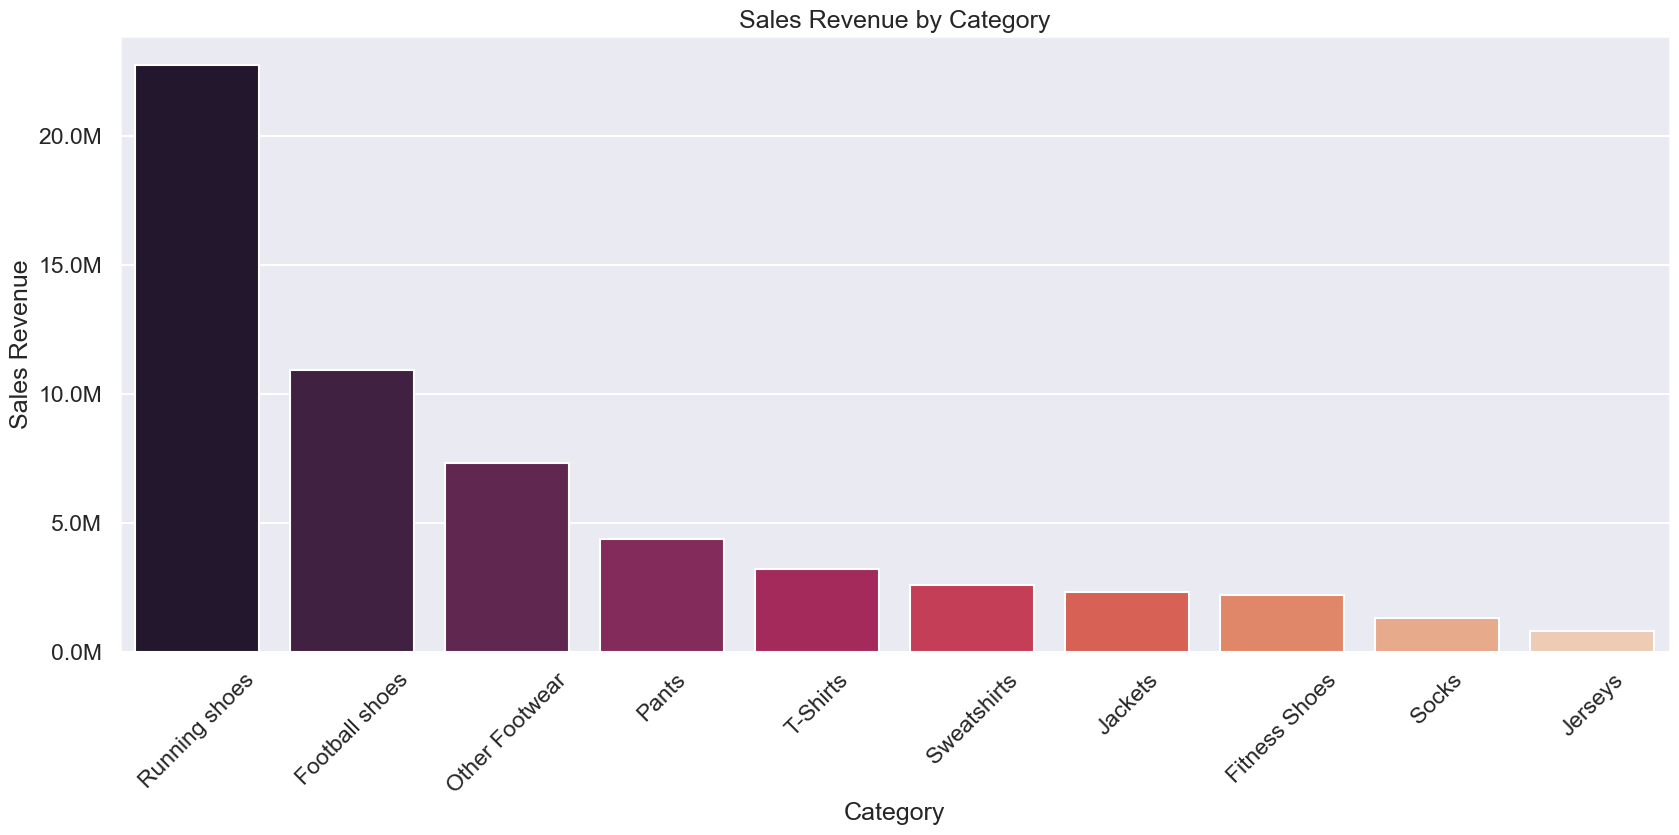

In [57]:
# plot sales revenue by top 10 countries
category_revenue = cleaned_df.groupby('group1')['sales_revenue'].sum().sort_values(ascending=False)

plt.figure(figsize=(20, 8))
sns.barplot(x=category_revenue.index[:10], y=category_revenue.values[:10], palette='rocket')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.ylabel('Sales Revenue')
plt.title('Sales Revenue by Category')

# format y-axis values to display in millions with one decimal place
formatter = ticker.FuncFormatter(lambda x, pos: '{:.1f}M'.format(x/1000000))
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

#### Best Selling Item by Sales Revenue

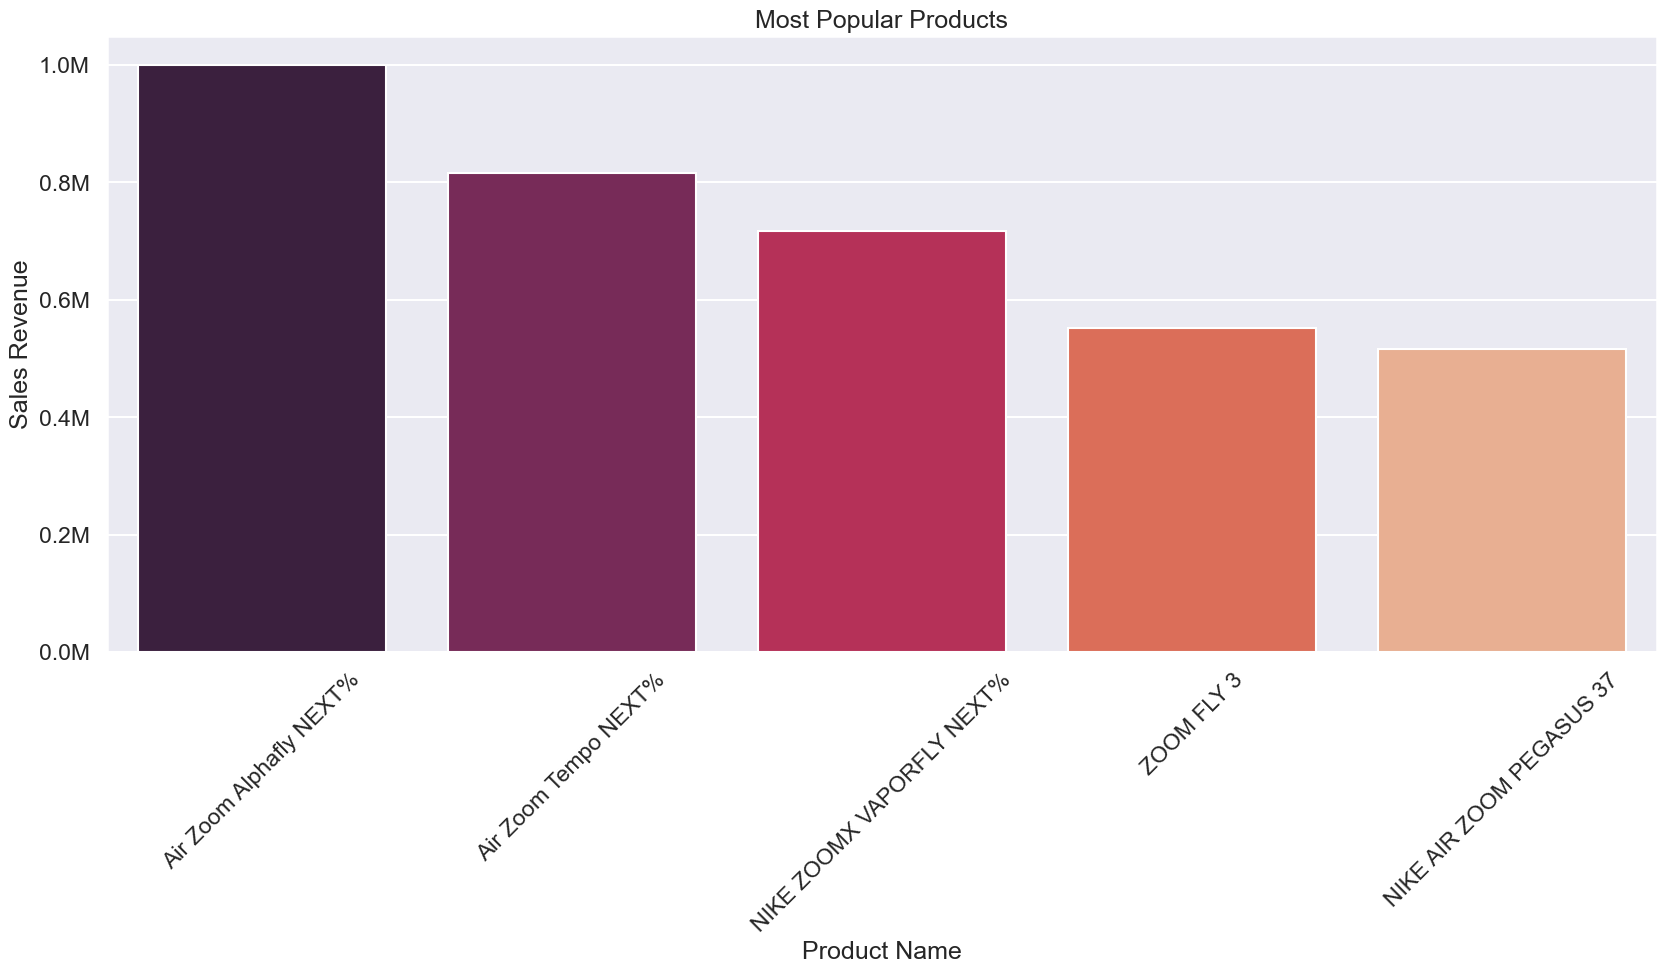

In [58]:
# get the highest selling product
highest_selling = cleaned_df.groupby('item_name')['sales_revenue'].sum().sort_values(ascending=False)

plt.figure(figsize=(20, 8))
sns.barplot(x=highest_selling.index[:5], y=highest_selling.values[:5], palette='rocket')
plt.xlabel('Product Name')
plt.xticks(rotation=45)
plt.ylabel('Sales Revenue')
plt.title('Most Popular Products')

# format y-axis values to display in millions with one decimal place
formatter = ticker.FuncFormatter(lambda x, pos: '{:.1f}M'.format(x/1000000))
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

#### Sales Revenue Over Time

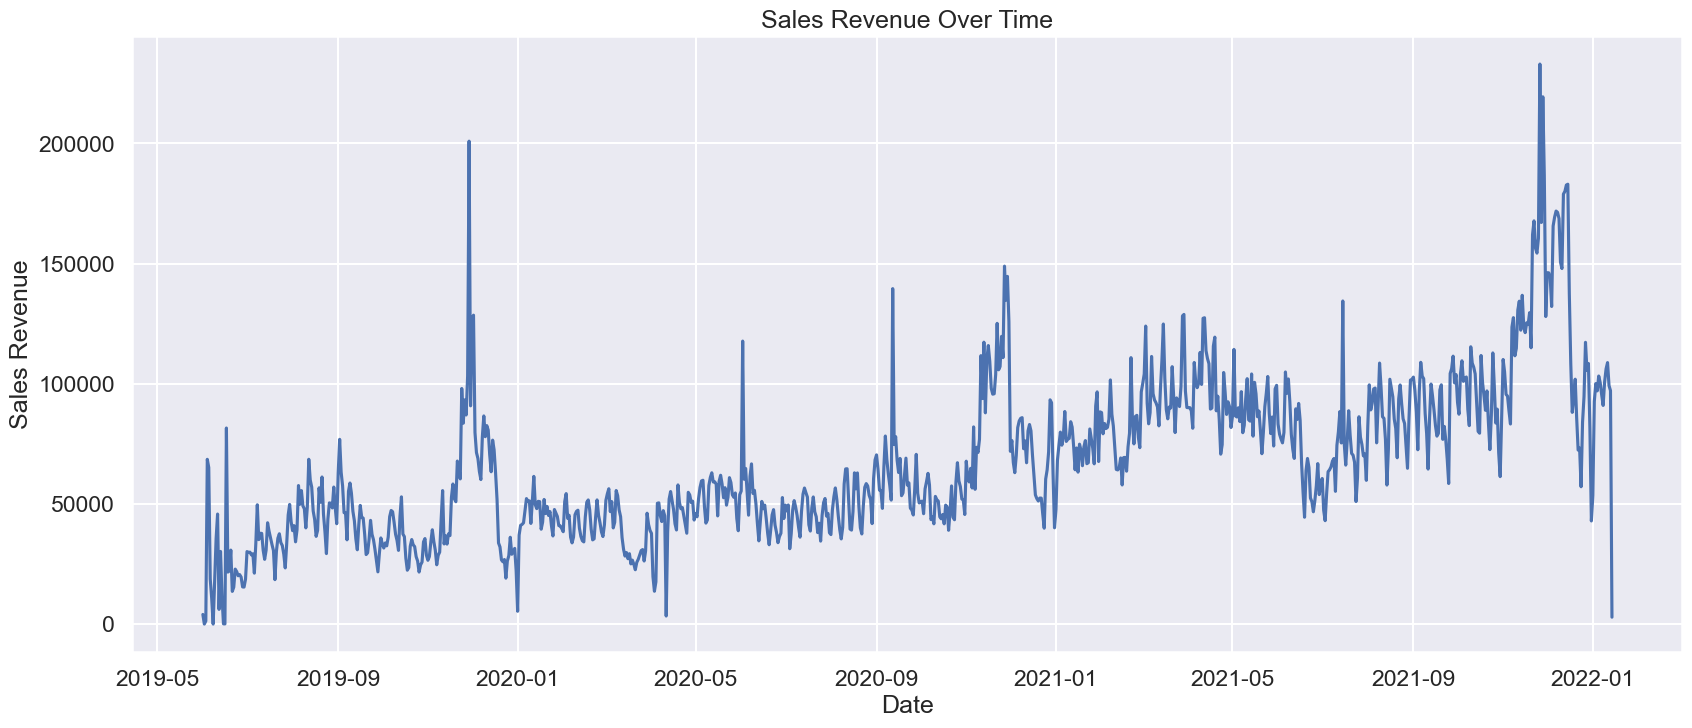

In [59]:
# group by date and calculate total sales revenue for each day
revenue_over_time = cleaned_df.groupby('date')['sales_revenue'].sum()

# plot line graph of daily sales revenue
plt.figure(figsize=(20, 8))
sns.lineplot(x=revenue_over_time.index, y=revenue_over_time.values)
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.title('Sales Revenue Over Time')

# format y-axis values to display in thousands with no decimal places
formatter = ticker.StrMethodFormatter('{x:.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

also similar plot with much less code:

In [60]:
# create revenue over time pandas series
revenue_over_time = cleaned_df.groupby('date')['sales_revenue'].sum()

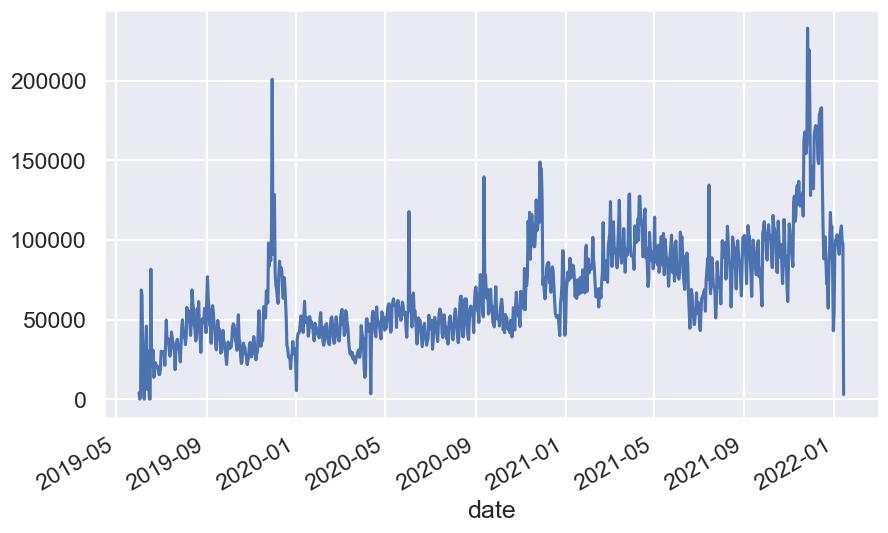

In [61]:
# set the figure size
plt.figure(figsize=(10, 6))

# plot the series
revenue_over_time.plot()

# show the plot
plt.show()

#### Order Volume Over Time

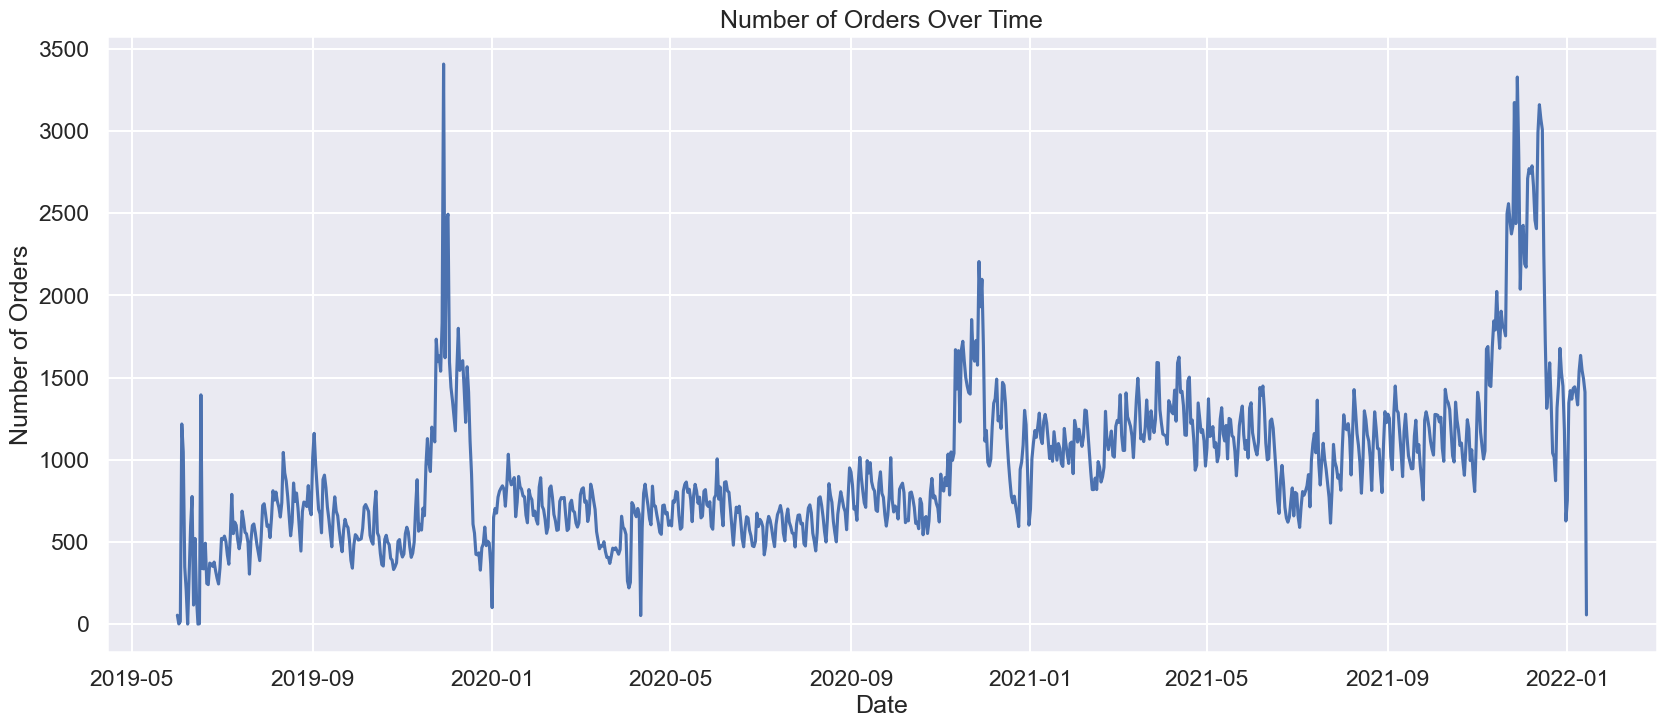

In [62]:
# group by date and count the number of orders for each day
orders_over_time = cleaned_df.groupby('date')['order_id'].nunique()

# plot line graph of daily number of orders
plt.figure(figsize=(20, 8))
sns.lineplot(x=orders_over_time.index, y=orders_over_time.values)
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.title('Number of Orders Over Time')
plt.show()

also similar plot with much less code:

In [63]:
orders_over_time = cleaned_df.groupby('date')['order_id'].nunique()

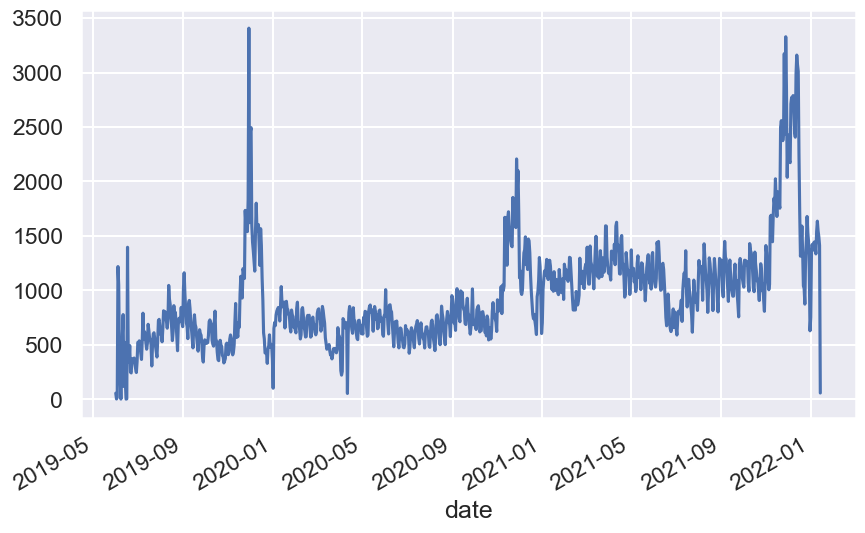

In [64]:
# set the figure size
plt.figure(figsize=(10, 6))

# plot the series
orders_over_time.plot()

# show the plot
plt.show()